# Exploring the 3W dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from ThreeWToolkit.dataset import ParquetDataset
from ThreeWToolkit.core.base_dataset import ParquetDatasetConfig

In this notebook, we will explore the *3W dataset* by examining missing data, analyzing the average values of the features, and demonstrating a simple example of data cleaning.

---------

## Loading the dataset

Define the folder where your dataset is stored. If the dataset is not found there, it will be downloaded automatically.

In [2]:
# Modify this path to the folder where your dataset is downloaded
dataset_path = "/data/3w_dataset"

Let's load the dataset in its raw format, without any data cleaning:

In [3]:
ds_config = ParquetDatasetConfig(path=dataset_path, clean_data=False) 
ds = ParquetDataset(ds_config)
len(ds)

[ParquetDataset] Dataset found at /data/3w_dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


2228

☝️ The dataset contains `2228` .parquet files.

The `ds` object is a collection of the content of each file.

Each element in `ds` is a dictionary containing 3 items:
- The signal
- The label (or sensor name)
- The file name

In [4]:
first_element = ds[0]

type(first_element), first_element.keys()

(dict, dict_keys(['signal', 'label', 'file_name']))

Let's gather the signal of each file and its average values:

In [5]:
averages, counts = [], []
for event in ds:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())

-------

## Checking missing data

In [6]:
total = sum(counts)
total

ABER-CKGL         8491513
ABER-CKP         12326458
ESTADO-DHSV      13865397
ESTADO-M1        17773205
ESTADO-M2        17688282
ESTADO-PXO       18176203
ESTADO-SDV-GL    17105271
ESTADO-SDV-P     24316107
ESTADO-W1        18938036
ESTADO-W2        18293462
ESTADO-XO        18538730
P-ANULAR         25460515
P-JUS-BS                0
P-JUS-CKGL       31896234
P-JUS-CKP        22115960
P-MON-CKGL         308726
P-MON-CKP        69507467
P-MON-SDV-P             0
P-PDG            68671102
PT-P                    0
P-TPT            71205535
QBS                     0
QGL              24565960
T-JUS-CKP        60554418
T-MON-CKP        23617605
T-PDG            20811272
T-TPT            66325278
state            72558918
dtype: int64

Which signals have a total of zero occurences (missing data)?

In [7]:
missing_columns = total[total == 0].index
missing_columns

Index(['P-JUS-BS', 'P-MON-SDV-P', 'PT-P', 'QBS'], dtype='object')

No single event in dataset contains any of these ☝️ tags.

P-MON-CKGL is also suspect. 🤔

---------

## Distribution of Signal Averages Across Events

Let's take a look at the distrubution of averages:

In [8]:
signals = counts[0].index
distribution = {s: [] for s in signals}

for signal in signals:
    for average, count in zip(averages, counts):
        if count[signal] != 0:
            distribution[signal].append(average[signal])

In [9]:
def plot_boxes(distribution):
    n_rows = int(np.ceil(np.sqrt(len(distribution))))
    n_cols = int(np.ceil(len(distribution) / n_rows))
    
    _, ax = plt.subplots(n_rows, n_cols, figsize=(16, 9), tight_layout=True)
    
    for i, (k, v) in enumerate(distribution.items()):
        ax[i // n_cols, i % n_cols].boxplot(v)
        ax[i // n_cols, i % n_cols].set_title(k)
        ax[i // n_cols, i % n_cols].grid()

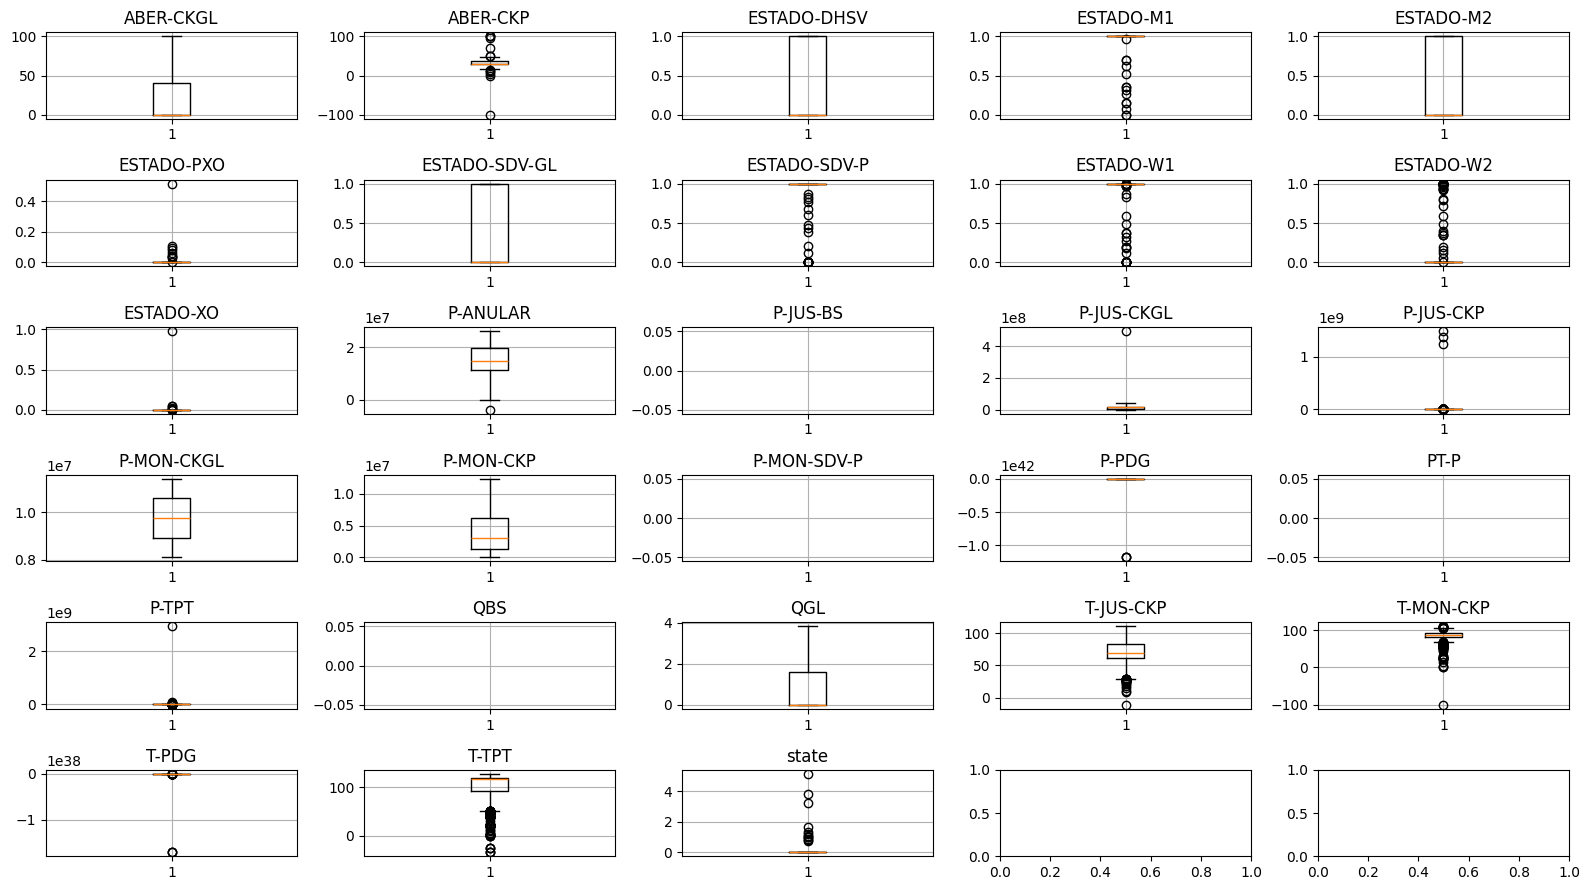

In [10]:
plot_boxes(distribution)

Affected Tags:
- `ABER-CKP`: Negative values
- `P-JUS-CKGL`: Readings capping scale
- `P-JUS-CKP`:  Readings capping scale
- `P-PDG`: same
- `P-TPT`: same
- `T-MON-CKP`: large negative values
- `T-PDG`: capping scale

The following solutions can be considered:
- Removing the affected files, which is easier but less accurate.
- Ignoring the apparently incorrect data, which is more complex and requires metadata.

---------------------------

## Data cleaning

By default, the dataset can be loaded with the configuration `tag clean_data=True`, which automatically applies three cleaning strategies:

- Removes invalid sensor readings through a cleanup process.
- Applies z-score normalization using global dataset statistics.
- Replaces missing values with 0, corresponding to the global mean after normalization.

Let's use the configuration tag `clean_data=True` and repeat the process to visualize the data.

In [11]:
ds_config = ParquetDatasetConfig(path=dataset_path, clean_data=True) 
ds = ParquetDataset(ds_config)
len(ds)

[ParquetDataset] Dataset found at /data/3w_dataset
[ParquetDataset] Validating dataset integrity...
[ParquetDataset] Dataset integrity check passed!


2228

Let's repeat the process and gather the signal of each file and its average values and deviations:

In [12]:
averages, counts = [], []
for event in ds:
    signal = event['signal']
    averages.append(signal.mean())
    counts.append(signal.count())

Tags that are mostly missing are removed.
Reading errors are sensibly removed.

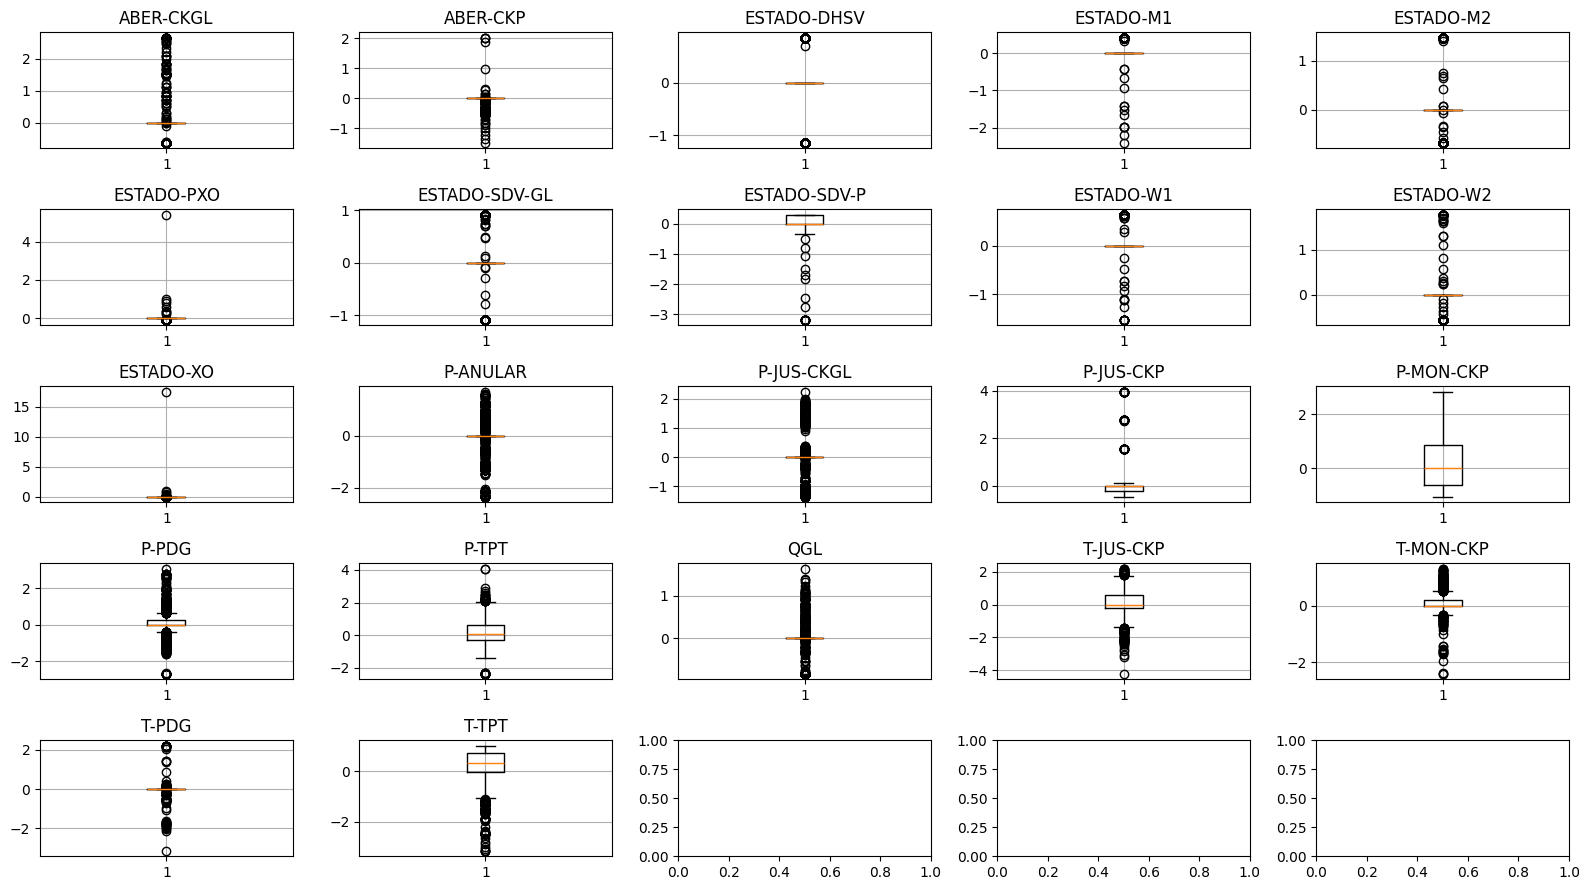

In [13]:
signals = counts[0].index
distribution = {s: [] for s in signals}

for s in signals:
    for a, c in zip(averages, counts):
        if c[s] != 0:
            distribution[s].append(a[s])
plot_boxes(distribution)

Do we have any missing data now? 🤔

In [14]:
total = sum(counts)
total

ABER-CKGL        76587318
ABER-CKP         76587318
ESTADO-DHSV      76587318
ESTADO-M1        76587318
ESTADO-M2        76587318
ESTADO-PXO       76587318
ESTADO-SDV-GL    76587318
ESTADO-SDV-P     76587318
ESTADO-W1        76587318
ESTADO-W2        76587318
ESTADO-XO        76587318
P-ANULAR         76587318
P-JUS-CKGL       76587318
P-JUS-CKP        76587318
P-MON-CKP        76587318
P-PDG            76587318
P-TPT            76587318
QGL              76587318
T-JUS-CKP        76587318
T-MON-CKP        76587318
T-PDG            76587318
T-TPT            76587318
dtype: int64

🎉 No missing data!

It is now possible to compute, for instance, global averages/deviations:

In [15]:
global_avg = sum(a.fillna(0) * c / total for a, c in zip(averages, counts))
global_avg

ABER-CKGL       -5.986547e-09
ABER-CKP        -2.684145e-08
ESTADO-DHSV     -4.468892e-09
ESTADO-M1       -2.007253e-08
ESTADO-M2        1.038615e-08
ESTADO-PXO      -4.482965e-10
ESTADO-SDV-GL   -1.622565e-09
ESTADO-SDV-P    -3.107196e-08
ESTADO-W1       -2.236688e-08
ESTADO-W2        2.141633e-08
ESTADO-XO        8.442492e-10
P-ANULAR        -8.404342e-08
P-JUS-CKGL       8.598653e-08
P-JUS-CKP       -4.228854e-08
P-MON-CKP       -2.631711e-08
P-PDG            8.529050e-08
P-TPT            3.628413e-07
QGL             -1.092824e-08
T-JUS-CKP       -2.128697e-08
T-MON-CKP        1.429295e-08
T-PDG            3.912037e-10
T-TPT            1.155634e-07
dtype: float64

and for the deviations:

In [16]:
counts, deviations = [], []
for event in ds:
    signal = event['signal']
    deviations.append((signal - global_avg).pow(2).mean())
    counts.append(signal.count())


In [17]:
global_std = sum(d.fillna(0) * c / total for d, c in zip(deviations, counts)).pow(0.5)
global_std

ABER-CKGL        0.332977
ABER-CKP         0.398538
ESTADO-DHSV      0.425488
ESTADO-M1        0.481731
ESTADO-M2        0.480579
ESTADO-PXO       0.487162
ESTADO-SDV-GL    0.472592
ESTADO-SDV-P     0.563467
ESTADO-W1        0.497266
ESTADO-W2        0.488731
ESTADO-XO        0.491996
P-ANULAR         0.570571
P-JUS-CKGL       0.638111
P-JUS-CKP        0.518741
P-MON-CKP        0.952659
P-PDG            0.814300
P-TPT            0.951502
QGL              0.566355
T-JUS-CKP        0.888979
T-MON-CKP        0.553413
T-PDG            0.314831
T-TPT            0.912850
dtype: float64